Device requirement for QWEN2-VL-2B-GPTQ-INT4-Model - Minimum - 5 GB CPU RAM and 8 GB GPU RAM - and additional memory for file storage and docker layers.


In [ ]:
!apt-get update
!apt-get install poppler-utils -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [61.9 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,642 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Package

In [ ]:
!python -m pip install git+https://github.com/huggingface/transformers torch torchvision torchaudio optimum auto-gptq
!pip install torch torchvision torchaudio scikit-learn pdf2image --extra-index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib seaborn openpyxl pandas

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-w94xmoeo
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-w94xmoeo
  Resolved https://github.com/huggingface/transformers to commit f63829c87bd89a4a0cea45d81c1cd870996b30c4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s

In [ ]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

from pdf2image import convert_from_path
from sklearn.metrics import confusion_matrix, classification_report
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from collections import Counter
import openpyxl
from openpyxl.styles import PatternFill

Mounted at /content/drive


In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [ ]:
folder_to_label_map = {
    "bill_of_lading": "Bill of Lading",
    "customs_document": "Customs Document",
    "delivery_receipt": "Delivery Receipt",
    "invoice": "Invoice",
    "lumper": "Lumper Ticket",
    "miscellaneous": "Miscellaneous",
    "noa": "Notice of Assignment",
    "roa": "Release of Assignment",
    "other_internal_documents": "Other Internal Documents",
    "proof_of_delivery": "Proof of Delivery",
    "rate_confirmation": "Rate Confirmation",
    "weight_ticket": "Weight Ticket",
}
known_labels = list(folder_to_label_map.values())

In [ ]:
def load_model_and_processor(model_name):
    print(f"Loading model: {model_name} ...")
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,  # or float16 if needed
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(model_name)
    print("Model loaded successfully.")
    return model, processor

In [ ]:
def convert_pdf_to_images(pdf_path, dpi=150, max_pages=None):
    images = []
    try:
        pages = convert_from_path(pdf_path, dpi)
        if max_pages is not None:
            pages = pages[:max_pages]
        images = pages
    except Exception as e:
        print(f"Error converting PDF {pdf_path}: {e}")
    return images

In [ ]:
def merge_pages_vertically(image_list):
    """
    Merge multiple PIL images vertically into a single tall image.
    """
    if len(image_list) == 1:
        # Only one page => no need to merge
        return image_list[0]

    # Get widths & heights
    widths, heights = zip(*(img.size for img in image_list))
    total_height = sum(heights)
    max_width = max(widths)

    # Create a new blank "canvas"
    merged_image = Image.new('RGB', (max_width, total_height), color=(255,255,255))
    y_offset = 0
    for img in image_list:
        merged_image.paste(img, (0, y_offset))
        y_offset += img.height

    return merged_image

In [ ]:
def open_document_as_merged_image(file_path):
    """
    1) If it's a single-page image (.jpg/.png), just return it.
    2) If it's a multi-page PDF, merge all pages vertically.
    3) Return one final PIL image or None if it fails.
    """
    file_path_lower = file_path.lower()

    # Single image?
    if file_path_lower.endswith((".jpg", ".jpeg", ".png")):
        try:
            return Image.open(file_path)
        except Exception as e:
            print(f"Error opening image {file_path}: {e}")
            return None

    # Multi-page PDF
    elif file_path_lower.endswith(".pdf"):
        pages = convert_pdf_to_images(file_path, dpi=300, max_pages=None)
        if not pages:
            return None
        if len(pages) == 1:
            return pages[0]
        else:
            return merge_pages_vertically(pages)

    else:
        # Unsupported extension
        return None

In [ ]:
# def build_domain_prompt(known_labels):
#     """
#     Builds a prompt that:
#     1) First shows the exact textual labels we want from known_labels.
#     2) Then provides detailed patterns as context for each category.
#     3) Emphasizes that the final output must be one textual label (no numbers).
#     """

#     # Convert your known_labels list into a single comma-separated string:
#     # e.g. "Bill of Lading, Customs Document, Delivery Receipt, ..."
#     labels_str = ", ".join(known_labels)

#     # Put the label references up front
#     main_prompt = f"""
# Your final answer must be EXACTLY one of these textual labels, nothing else:
# {labels_str}

# IGNORE any numeric references or partial text.
# If uncertain, pick the single best match from those labels.

# Additional context patterns for each category (to help you decide):

# - Lumper Ticket:
#   It is a reciept that contains ticket #, location, work date, carrier, dock, door, load info, payments details.

# - Other Internal Documents:
#   It has bold headings such as payment options, instapay payment instructions, regular payment instructions,
#   submission instructions and the traffix company logo (often in a tabular format).

# - Customs Document:
#   It is related to delivery inspection by customs officer/department,
#   may contain barcodes, conveyance reference no., carrier, truck/trailer info, etc.

# - Miscellaneous:
#   could have random big logos (email/Instagram or CSA, Schneider),
#   no consistent pattern

# - Release of Assignment (ROA):
#   This image has text with phrases like "no longer factoring", "discontinued servicing", or
#   "notice of release"/"release stamp"

# - Proof of Delivery:
#   This image has Bill of Lading writte on it but also additionally has pen-signed name/time (signature),
#   different from Delivery Receipt which might not have a penned signature/time.

# - Rate Confirmation:
#   originally 3 pages,
#   3rd page: terms & conditions,
#   1st page: traffix logo, load #, carrier info,
#   2nd page: shipper/consignee notes, etc.

# - Weight Ticket:
#   trucks' weighing/scaling info (net/gross weight)

# - Bill of Lading:
#   standard shipping doc, might say "Bill of Lading"

# - Invoice:
#   line items, amounts due, "invoice #", might say "Invoice"

# - Delivery Receipt:
#   shows delivered goods, references Bill of Lading #,
#   but no explicit pen-signed date/time

# - Notice of Assignment:
#   factoring or assignment references "Notice of Assignment"

# Remember: produce EXACTLY one label from:
# {labels_str}
# """.strip()

#     return main_prompt

In [ ]:
def build_domain_prompt(known_labels):
    """
    Builds a refined prompt for the model, integrating specific keywords
    for highly misclassified categories to enhance classification accuracy.
    """
    labels_str = ", ".join(known_labels)

    main_prompt = f"""
Your final answer must be EXACTLY one of these textual labels, nothing else:
{labels_str}

IGNORE any numeric references or partial text.
If uncertain, pick the single best match from those labels.

Additional context patterns for each category (to help you decide):

- Bill of Lading:
  Standard shipping document, might say "Bill of Lading".

- Customs Document:
  Related to delivery inspection by customs officer/department,
  may contain barcodes, conveyance reference no., carrier, truck/trailer info, etc.

- Delivery Receipt:
  Shows delivered goods, references Bill of Lading #,
  but no explicit pen-signed date/time.
  **Keywords:** Delivery receipt, Maintain Temperature at:, No of Pieces, EMS No, Unit of Measure, Sales order number.

- Invoice:
  Line items, amounts due, "invoice #", might say "Invoice".

- Lumper Ticket:
  Receipt that contains ticket #, location, work date, carrier, dock, door, load info, payments details.
  **Keywords:** lumper Receipt, lumpering ticket, unloading invoice, Loading / Unloading receipt, ACE ENDICO, BW Logistics, Capstone Logistics, LLC, Carol-Marbel Lumper Services, CDI, CDS-Comprehensive Distribution Services, Eclipse Advantage, Express Freight Handlers, Inc, FHI, LLC, Freight Handlers Inc, Freight Specialists, Inc, IDS Lumper, IRA Higdon, MIH Freight Handlers, Quality Lumper Service, Quality Lumping Service, LLC, Southeast Unloading, TW Services, Universal Lumper, Universal Lumper Service, Universal Lumpers, American Freight Service, Quality Lumping Service LLC, Merit Logistics, Universal Chain, Inc, Capstone, Capstone Logistics, Carol Marbel Lumper, CDS Comprehensive, Eclipse, Express Freight Handlers, FHI, Freight Handlers, Freight Specialists, Quality Lumping Service, Universal Chain, Carol Marbel Lumper, FrezNstor Inc, FrezNstor, Scavuzzo Incorporated, Scavuzzo, CRB Unloading, GRB Unloading, Harvest, Warehouse Labor Solutions, Warehouse Labor, BAM Labor Logistics, US Cold Storage - McDonough 1, US Cold Storage, KeHE Distributors, Lumping receipt, My love Rewards, Loyalty Member, Invoice Number, Invoice Date, Reference:, Billed To, INV AMOUNT, INV DATE, PO #, INV #, STATEMENT, REF #, Print Date, Total Charges:, ALL BILLS PRESENTED ON THIS STATEMENT HAVE BEEN SOLD & ASSIGNED TO AND ARE PAYABLE TO:, (USD) Total Rate, Payment due upon receipt, Due Date:, BILLING TERMS:, PAYMENT TERMS:, DUE DATE:, Your Reference Nbr:, Invoice Total:, Shipper:, Payable To:, BALANCE DUE, W/O (ref), Load Details, Notes:, fax:.

- Miscellaneous:
  Could have random big logos (email/Instagram or CSA, Schneider),
  no consistent pattern.

- Notice of Assignment:
  Factoring or assignment references "Notice of Assignment".

- Release of Assignment:
  Text with phrases like "no longer factoring", "discontinued servicing", "notice of release"/"release stamp",
  "NOTICE OF ASSIGNMENT RELEASE", "Full Release", "is no longer servicing this factoring", "Client is no longer factoring",
  "Notice of release and sale of accounts", "Letter of release", "No Longer handling the account",
  "terminate", "cancellation", "directly to", "voided", "ATTN:", "Release of assignment", "DOT#", "WMT",
  "FED ID #:", "Acknowledged:".

- Other Internal Documents:
  Has bold headings such as payment options, instapay payment instructions, regular payment instructions,
  submission instructions and the traffix company logo (often in a tabular format).

- Proof of Delivery:
  Image has "Bill of Lading" written on it but also has a pen-signed name/time (signature),
  different from Delivery Receipt which might not have a penned signature/time.
  **Keywords:** POD, Proof of delivery, Seal #, Rel #, Maintain Temperature at:, No of Pieces, EMS No, Unit of Measure, Sales order number.

- Rate Confirmation:
  Originally 3 pages,
  3rd page: terms & conditions,
  1st page: traffix logo, load #, carrier info,
  2nd page: shipper/consignee notes, etc.

- Weight Ticket:
  Trucks' weighing/scaling info (net/gross weight).

Remember: produce EXACTLY one label from:
{labels_str}
""".strip()

    return main_prompt


In [ ]:
def force_to_nearest_label(pred_text, known_labels):
    import difflib
    best = difflib.get_close_matches(pred_text, known_labels, n=1, cutoff=0.3)
    return best[0] if best else pred_text

In [ ]:
def classify_image(pil_image, model, processor):
    """
    Classify the tall merged image with Qwen2-VL, using the refined domain prompt
    that explicitly lists known labels and provides context.
    """
    if pil_image is None:
        return ""

    # Build the prompt using the known_labels
    user_prompt = build_domain_prompt(known_labels)

    # Create the message with the doc (image) + textual context
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": user_prompt}
            ]
        }
    ]

    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        text=[text_prompt],
        images=[pil_image],
        padding=True,
        return_tensors="pt"
    ).to("cuda")

    # Increase max tokens to allow enough space for textual output
    output_ids = model.generate(**inputs, max_new_tokens=40)
    generated_ids = [
        output_ids[len(input_ids):]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    if not output_text:
        return ""

    raw_pred = output_text[0].strip()

    # Map the raw text to the closest known label if it tries partial or numeric
    final_label = force_to_nearest_label(raw_pred, known_labels)
    return final_label


In [ ]:
def evaluate_model(
    azure_files_path,
    folder_names,
    model,
    processor,
    category_map,
    output_xlsx="classification_results.xlsx"
):
    """
    Evaluates classification by:
    1) Limiting to 10 documents per folder.
    2) Merging multi-page docs into a single image (open_document_as_merged_image).
    3) Classifying using classify_image(...).
    4) Producing confusion matrix, classification report, color-coded Excel.
    """
    all_expected = []
    all_predicted = []
    all_filenames = []

    valid_exts = (".jpg", ".jpeg", ".png", ".pdf")

    for folder in folder_names:
        folder_path = os.path.join(azure_files_path, folder)
        if not os.path.isdir(folder_path):
            print(f"Warning: folder does not exist -> {folder_path}")
            continue

        expected_label = category_map[folder]
        docs = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
        docs = docs[:10]  # only classify up to 10 docs per folder

        for doc_file in docs:
            doc_path = os.path.join(folder_path, doc_file)
            merged_img = open_document_as_merged_image(doc_path)
            if merged_img is None:
                print(f"Warning: Could not load/merge {doc_file}. Skipping.")
                continue

            predicted_label = classify_image(merged_img, model, processor)
            all_expected.append(expected_label)
            all_predicted.append(predicted_label)
            all_filenames.append(doc_file)
            print(f"[EVAL] Document: {doc_file} | Expected: {expected_label} | Predicted: {predicted_label}")

    # Confusion matrix & heatmap
    print("\nGenerating confusion matrix & classification report ...\n")
    cm = confusion_matrix(all_expected, all_predicted, labels=list(category_map.values()))
    df_cm = pd.DataFrame(cm, index=list(category_map.values()), columns=list(category_map.values()))

    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Expected")
    plt.show()

    print("\nClassification Report ->")
    report = classification_report(
        all_expected,
        all_predicted,
        labels=list(category_map.values()),
        target_names=list(category_map.values()),
        zero_division=0
    )
    print(report)

    # Print summary per category
    print("\nPer-Category Results:\n")
    for lbl in category_map.values():
        total = sum(1 for e in all_expected if e == lbl)
        correct = sum(
            1
            for i in range(len(all_expected))
            if all_expected[i] == lbl and all_predicted[i] == lbl
        )
        print(f"{lbl}: {correct} correct out of {total}")

    # Save to Excel with color-coded rows
    print(f"\nSaving results to {output_xlsx} ...")
    wb = openpyxl.Workbook()
    ws = wb.active
    ws.title = "Classification_Results"

    ws.append(["FILE_NAME", "EXPECTED_RESULT", "PREDICTED_RESULT"])
    header_fill = PatternFill(start_color="D9D9D9", end_color="D9D9D9", fill_type="solid")
    for cell in ws[1]:
        cell.fill = header_fill

    green_fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")
    red_fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")

    for fname, exp, pred in zip(all_filenames, all_expected, all_predicted):
        ws.append([fname, exp, pred])
        row_idx = ws.max_row
        if exp == pred:
            for c in ws[row_idx]:
                c.fill = green_fill
        else:
            for c in ws[row_idx]:
                c.fill = red_fill

    wb.save(output_xlsx)
    print(f"Done! Excel file created: {output_xlsx}")

Loading model: Qwen/Qwen2-VL-2B-Instruct-GPTQ-Int4 ...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.48G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


generation_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Model loaded successfully.
[EVAL] Document: 006a5c7b-92fd-4c93-8822-44b772d3e795_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Bill of Lading
[EVAL] Document: 00741aac-9cb7-46dd-a3f5-6a20edef08a4_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Bill of Lading
[EVAL] Document: 0049ea14-e513-4eb1-a28d-44a485e0fe59_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Bill of Lading
[EVAL] Document: 00b13cd9-2099-4e09-a63f-b521437bab90_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Bill of Lading
[EVAL] Document: 008f94ce-8565-4cb6-a470-254dec8ee706_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Delivery Receipt
[EVAL] Document: 004d7f36-6b97-43e6-bf34-1b15bff0f776_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Bill of Lading
[EVAL] Document: 0042c0ae-19f6-4c65-9137-ec4459dcfd80_bill_of_lading.pdf | Expected: Bill of Lading | Predicted: Bill of Lading
[EVAL] Document: 00a39371-3e89-4054-845e-a6916d887da7_bill_of_lading.pdf | 

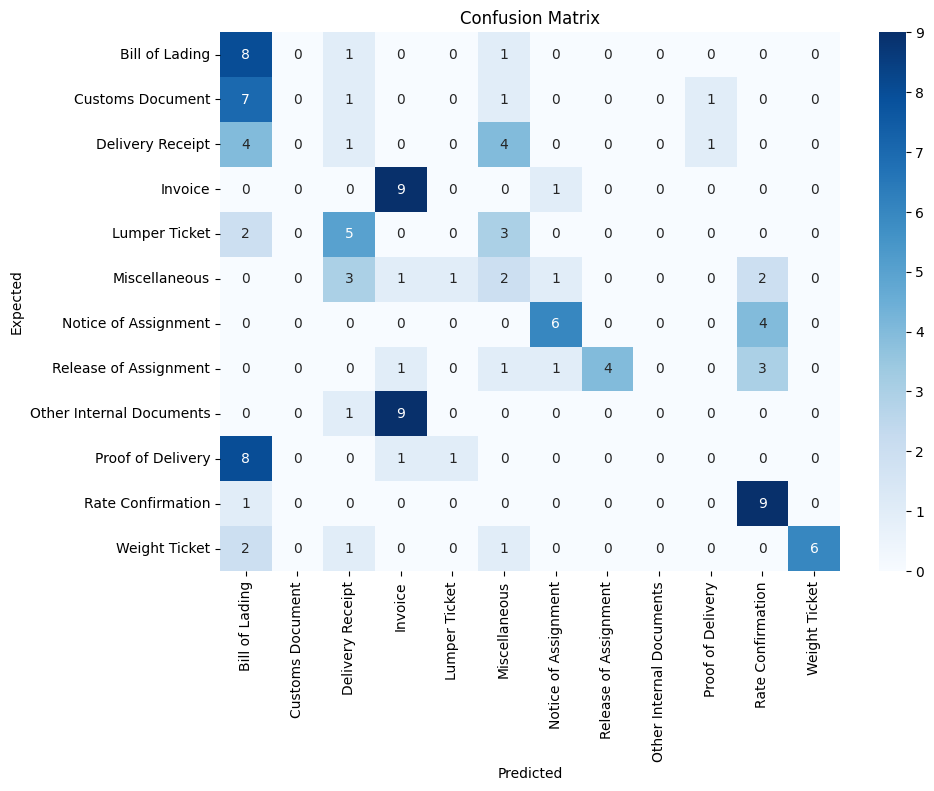


Classification Report ->
                          precision    recall  f1-score   support

          Bill of Lading       0.25      0.80      0.38        10
        Customs Document       0.00      0.00      0.00        10
        Delivery Receipt       0.08      0.10      0.09        10
                 Invoice       0.43      0.90      0.58        10
           Lumper Ticket       0.00      0.00      0.00        10
           Miscellaneous       0.15      0.20      0.17        10
    Notice of Assignment       0.67      0.60      0.63        10
   Release of Assignment       1.00      0.40      0.57        10
Other Internal Documents       0.00      0.00      0.00        10
       Proof of Delivery       0.00      0.00      0.00        10
       Rate Confirmation       0.50      0.90      0.64        10
           Weight Ticket       1.00      0.60      0.75        10

                accuracy                           0.38       120
               macro avg       0.34      0.38   

In [ ]:
if __name__ == "__main__":
    azure_files_path = "/content/drive/MyDrive/azure_files"

    folder_names = [
        "bill_of_lading",
        "customs_document",
        "delivery_receipt",
        "invoice",
        "lumper",
        "miscellaneous",
        "noa",
        "roa",
        "other_internal_documents",
        "proof_of_delivery",
        "rate_confirmation",
        "weight_ticket"
    ]

    model_name = "Qwen/Qwen2-VL-2B-Instruct-GPTQ-Int4"
    model, processor = load_model_and_processor(model_name)

    evaluate_model(
        azure_files_path=azure_files_path,
        folder_names=folder_names,
        model=model,
        processor=processor,
        category_map=folder_to_label_map,
        output_xlsx="classification_results.xlsx"
    )